For this to work, place in the ``/examples`` directory of the [Jordan et al. (2019)](https://arxiv.org/pdf/1903.08778.pdf) paper repo: https://github.com/revbucket/geometric-certificates.

Furthermore, the requirements for this can be installed using the ``requirements_plot.txt`` found in this repo. The model training part of is more or less adapted from their example notebook found [here](https://github.com/revbucket/geometric-certificates/blob/master/examples/2D_example.ipynb).

The data generation part was taken from Pacmed's [repo for uncertainty estimation on electronic health records](https://github.com/Pacmed/ehr_ood_detection), more specifically this notebook [here](https://github.com/Pacmed/ehr_ood_detection/blob/master/notebooks/multiclass_uncertainty.ipynb).


In [102]:
import sys 
sys.path.append('.')
sys.path.append('..')

import pandas as pd
import sklearn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from geocert import GeoCert
from _polytope_ import Polytope
import polytope as ptope
from utilities import plot_polytopes_2d, Polytope_2
from plnn import PLNN

In [ ]:
# Define some constants here that stay fixed for the entire notebook



## Data generation

This block just generated 10 clusters of points following different 

In [200]:
# Ugly data generation
positive_size, negative_size = 50, 50 

def generate_cluster(mean, diag_cov, size, label):
    c = np.random.multivariate_normal(mean=mean, cov=[[diag_cov, 0],[0,diag_cov]], size=size)
    c = np.expand_dims(c, 2)
    y = np.ones(shape=(c.shape[0],1,1))*label
    c = np.concatenate([c, y], axis=1)
    return c

one_mean = np.array([ 0.5, -0.5])
two_mean = np.array([0,-1.5])
three_mean = np.array([-1.3,-1])
four_mean = np.array([-1.5,0])
five_mean = np.array([-0.1,0.5])
six_mean = np.array([ -2.5, 0.5])
seven_mean = np.array([ 1.5, 0])
eight_mean = np.array([2, 1.1])
nine_mean = np.array([2, -1.5])
one_cluster = generate_cluster(one_mean, np.random.uniform(0.02,0.1), positive_size, label=0)
two_cluster = generate_cluster(two_mean, np.random.uniform(0.02,0.1), negative_size, label=1)
three_cluster = generate_cluster(three_mean, np.random.uniform(0.02,0.1), negative_size, label=2)
four_cluster = generate_cluster(four_mean, np.random.uniform(0.02,0.1), negative_size, label=3)
five_cluster = generate_cluster(five_mean, np.random.uniform(0.02,0.1), negative_size, label=4)
six_cluster = generate_cluster(six_mean, np.random.uniform(0.02,0.1), negative_size, label=5)
seven_cluster = generate_cluster(seven_mean, np.random.uniform(0.02,0.1), negative_size, label=6)
eight_cluster = generate_cluster(eight_mean,np.random.uniform(0.02,0.1), negative_size, label=7)
nine_cluster = generate_cluster(nine_mean,np.random.uniform(0.02,0.1), negative_size, label=8)
concatenated = np.concatenate([one_cluster, two_cluster, three_cluster, four_cluster, 
                               five_cluster, six_cluster, seven_cluster, eight_cluster, nine_cluster], axis=0)

columns = ['f1', 'f2']
label = 'label'
df_model = pd.DataFrame(concatenated[:,:,0], columns=columns+[label])
df_model = sklearn.utils.shuffle(df_model, random_state=1)

X = torch.FloatTensor(df_model[columns].values)
y = torch.LongTensor(df_model[label].values)

print(X.shape, y.shape)

step_size = .1 
x_min, x_max = -3.5,3.1
y_min, y_max = -3.5,3.1


xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                     np.arange(y_min, y_max, step_size))

X_grid = np.c_[xx.ravel(), yy.ravel()]


torch.Size([450, 2]) torch.Size([450])


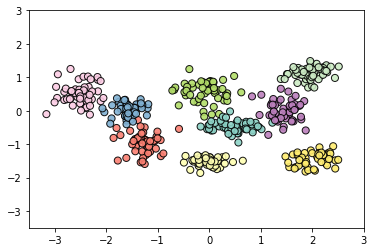

In [232]:
# Quick check on how the clusters are looking 

plt.figure(figsize=(6,4))
axes = plt.gca()
axes.set_xlim([-3.5,3])
axes.set_ylim([-3.5,3])
plt.scatter(X_train[:, 0], X[:, 1],  c=y, cmap='Set3',
                edgecolors='k', alpha=0.9, s=50)

In [77]:
class SimpleDataset(Dataset):

    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):

        return self.X.shape[0]

    def __getitem__(self, idx: int):

        return self.X[idx], self.y[idx]

In [201]:
# Training block -- train a simple 2d Network 
# --- define network 
plnn_obj = PLNN(layer_sizes=[2, 5, 5, 9])
net = plnn_obj.net

# --- train network 
n_epochs = 100
opt = optim.Adam(net.parameters(), lr=0.001)
for _ in range(n_epochs):
    for i, (batch_X, batch_y) in enumerate(DataLoader(SimpleDataset(X, y), batch_size=8, shuffle=True)):
        out = net(Variable(batch_X))
        l = nn.CrossEntropyLoss()(out, Variable(batch_y))
        err = (out.max(1)[1].data !=  batch_y).float().mean()
        if i % 100 == 0:
            print(l.item(), err)
        opt.zero_grad()
        (l).backward()
        opt.step()
print(l.item())

[2, 5, 5, 9]
2.25626802444458 tensor(0.8750)
2.1428275108337402 tensor(0.8750)
2.1448020935058594 tensor(0.8750)
1.9763641357421875 tensor(0.8750)
1.7910945415496826 tensor(0.6250)
1.7914129495620728 tensor(0.7500)
1.5935004949569702 tensor(0.6250)
0.9998733997344971 tensor(0.2500)
1.1521351337432861 tensor(0.3750)
1.0414493083953857 tensor(0.3750)
1.315101146697998 tensor(0.6250)
1.2320650815963745 tensor(0.3750)
1.0016493797302246 tensor(0.5000)
0.7870252132415771 tensor(0.1250)
0.7587624192237854 tensor(0.)
0.6884024143218994 tensor(0.2500)
0.556058406829834 tensor(0.1250)
0.4809257686138153 tensor(0.)
0.4926582872867584 tensor(0.1250)
0.6960121989250183 tensor(0.3750)
0.5856029391288757 tensor(0.2500)
0.561272144317627 tensor(0.1250)
0.37022864818573 tensor(0.)
0.32054364681243896 tensor(0.)
0.4205127954483032 tensor(0.)
0.4078606069087982 tensor(0.1250)
0.46358126401901245 tensor(0.2500)
0.5376060605049133 tensor(0.3750)
0.409792423248291 tensor(0.)
0.4158748388290405 tensor(0.250

## Plotting 

Next, we define some plotting functions here. We want to produce the following plots: 

    1. Plots of the 

In [233]:
# Now plot uncertainty via predictive entropy
def plot_single_grid(X, y, xx, yy, grid, alpha=0.1, s=50, title='', 
                     vmin=None, vmax=None):
    plt.figure(figsize=(6,4))
    axes = plt.gca()
    axes.set_xlim([-3.5,3])
    axes.set_ylim([-3.5,3])
    cmap = plt.cm.Purples
    c = plt.contourf(xx, yy, grid.reshape(xx.shape), cmap=cmap,
                    levels=40, vmin=vmin, vmax=vmax)
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', 
                edgecolors='k', alpha=alpha, s=s)
    #plt.axis('off')
    plt.title(title)
    
def entropy(preds, dim):
    return -torch.sum(preds * torch.log2(preds+1e-8), dim=dim)

In [236]:
def plot_polytopes_and_points(X, y, poly_list, xlim=[-3.5,3], ylim=[-3.5,3]):
    plt.close()
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    for poly in poly_list:
        P = Polytope_2(poly.ub_A, poly.ub_b)
        V = ptope.extreme(P)

        if V is not None:
            P.plot(ax, color="white", alpha=0.8, linewidth=1, linestyle="-")
        else:
            # Polytope may be unbounded, thus add additional constraints x in [-xylim, xylim]
            # and y in [-xylim, xylim]
            new_ub_A = np.vstack((poly.ub_A, [[1,0],[-1,0],[0,1],[0,-1]]))
            new_ub_b = np.hstack((poly.ub_b, [xlim[1], -1*xlim[0], ylim[1], -1*ylim[0]]))
            P2 = Polytope_2(new_ub_A, new_ub_b)
            V2 = ptope.extreme(P2)
            if V2 is not None:
                P2.plot(ax, color="white", alpha=0.8, linewidth=1, linestyle="-")
                print('an unbounded polytope was plotted imperfectly')
            else:
                print('polytope not plotted')
    
    # Plot points
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', 
                edgecolors='k', alpha=0.9, s=50)
    
    plt.show()

In [ ]:
def plot_polytopes_2d(poly_list, colors=None, alpha=1.0,
                   xylim=5, ax=None, linestyle='dashed', linewidth=0):
    """Plots a list of polytopes which exist in R^2.
    """
    if ax is None:
        ax = plt.axes()
    if colors == None:
        colors = [np.random.rand(3) for _ in range(0, len(poly_list))]

    if(np.size(xylim)==1):
        xlim = [0, xylim]
        ylim = [0, xylim]
    else:
        xlim = xylim
        ylim = xylim

    for poly, color in zip(poly_list, colors):
        P = Polytope_2(poly.ub_A, poly.ub_b)
        V = ptope.extreme(P)

        if V is not None:
            P.plot(ax, color=color, alpha=alpha, linestyle=linestyle, linewidth=linewidth)
        else:
            # Polytope may be unbounded, thus add additional constraints x in [-xylim, xylim]
            # and y in [-xylim, xylim]
            new_ub_A = np.vstack((poly.ub_A, [[1,0],[-1,0],[0,1],[0,-1]]))
            new_ub_b = np.hstack((poly.ub_b, [xlim[1], -1*xlim[0], ylim[1], -1*ylim[0]]))
            P2 = Polytope_2(new_ub_A, new_ub_b)
            V2 = ptope.extreme(P2)
            if V2 is not None:
                P2.plot(ax, color=color, alpha=alpha, linestyle=linestyle, linewidth=linewidth)
                print('an unbounded polytope was plotted imperfectly')
            else:
                print('polytope not plotted')

    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])


In [238]:
def plot_everything(X, y, xx, yy, grid, poly_list, xlim=[-3.5,3], ylim=[-3.5,3]):
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
     # Plot uncertainty 
    cmap = plt.cm.Purples
    ax.contourf(xx, yy, grid.reshape(xx.shape), cmap=cmap,
                    levels=40, vmin=None, vmax=None, alpha=0.75)
    
    # Plot polytopes
    for poly in poly_list:
        P = Polytope_2(poly.ub_A, poly.ub_b)
        V = ptope.extreme(P)

        if V is not None:
            P.plot(ax, color="white", alpha=1, linewidth=3, linestyle="dashed")
        else:
            # Polytope may be unbounded, thus add additional constraints x in [-xylim, xylim]
            # and y in [-xylim, xylim]
            new_ub_A = np.vstack((poly.ub_A, [[1,0],[-1,0],[0,1],[0,-1]]))
            new_ub_b = np.hstack((poly.ub_b, [xlim[1], -1*xlim[0], ylim[1], -1*ylim[0]]))
            P2 = Polytope_2(new_ub_A, new_ub_b)
            V2 = ptope.extreme(P2)
            if V2 is not None:
                P2.plot(ax, color="white", alpha=1, linewidth=3, linestyle="dashed")
                print('an unbounded polytope was plotted imperfectly')
            else:
                print('polytope not plotted')
    
    # Plot points
    ax.scatter(X[:, 0], X[:, 1], c=y,cmap='Set1', 
                edgecolors='k', alpha=0.6, s=50)

    
    plt.show()

---Initial Polytope---
(p0) Popped: 0.001483  | 3.000000
(p0) Popped: 0.102729  | 3.000000
(p0) Popped: 0.157854  | 3.000000
(p0) Popped: 0.217277  | 3.000000
(p0) Popped: 0.234779  | 3.000000
(p0) Popped: 0.294633  | 3.000000
(p0) Popped: 0.299565  | 3.000000
(p0) Popped: 0.327234  | 3.000000
(p0) Popped: 0.369806  | 3.000000
(p0) Popped: 0.441195  | 3.000000
(p0) Popped: 0.495458  | 3.000000
(p0) Popped: 0.505224  | 3.000000
(p0) Popped: 0.505224  | 3.000000
(p0) Popped: 0.508011  | 3.000000
(p0) Popped: 0.509391  | 3.000000
(p0) Popped: 0.510982  | 3.000000
(p0) Popped: 0.543769  | 3.000000
(p0) Popped: 0.570529  | 3.000000
(p0) Popped: 0.578946  | 3.000000
(p0) Popped: 0.600368  | 3.000000
(p0) Popped: 0.672608  | 3.000000
(p0) Popped: 0.715734  | 3.000000
(p0) Popped: 0.734780  | 3.000000
(p0) Popped: 0.804527  | 3.000000
(p0) Popped: 0.839808  | 3.000000
(p0) Popped: 0.914277  | 3.000000
(p0) Popped: 0.928178  | 3.000000
(p0) Popped: 0.958090  | 3.000000
(p0) Popped: 1.000914  | 

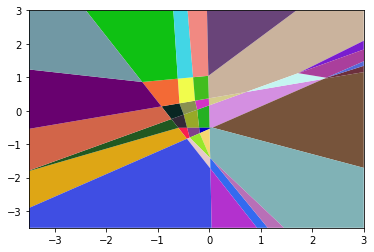

In [240]:
# Retrieve polytopes
geo = GeoCert(plnn_obj, hyperbox_bounds=(-3.5, 3), verbose=True, neuron_bounds="ia")
#geo.verbose = True # This will take a while, so let's turn on printouts

test_point = torch.Tensor([0, 0])
region_count = geo.run(test_point, lp_norm='l_inf', problem_type='count_regions', 
                       decision_radius=3)

polylist = []

print(vars(region_count).keys())

for polytope in region_count.seen_polytopes:
    config = plnn_obj.config_str_to_config_list(polytope)
    polytope_config = plnn_obj.compute_polytope_config(config)
    poly = Polytope.from_polytope_dict(polytope_config, test_point)
    polylist.append(poly)

plot_polytopes_2d(polylist, xylim=[-3.5, 3])

In [234]:
preds = torch.softmax(net(torch.FloatTensor(X_grid)), dim=1)
uncertainty = entropy(preds, dim=1).detach().numpy()

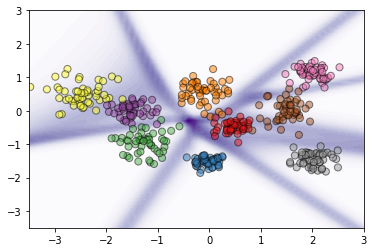

In [235]:
plot_single_grid(X, y, xx, yy, uncertainty, s=50, alpha=0.5,title='')

polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not 

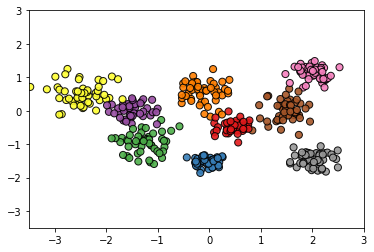

In [237]:
plot_polytopes_and_points(X, y, polylist)

polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not plotted
polytope not 

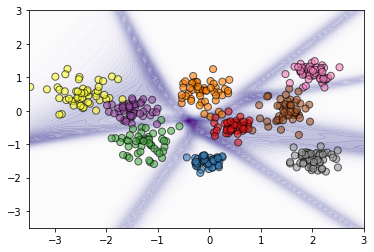

In [239]:
plot_everything(X, y, xx, yy, uncertainty, polylist)